In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/minist_overfit.zip

Archive:  /content/drive/MyDrive/minist_overfit.zip
   creating: data/test/
   creating: data/test/0/
 extracting: data/test/0/9802.png    
 extracting: data/test/0/9810.png    
 extracting: data/test/0/9819.png    
 extracting: data/test/0/9827.png    
 extracting: data/test/0/9851.png    
 extracting: data/test/0/9866.png    
 extracting: data/test/0/9880.png    
 extracting: data/test/0/9886.png    
 extracting: data/test/0/9898.png    
 extracting: data/test/0/9903.png    
 extracting: data/test/0/9912.png    
 extracting: data/test/0/9931.png    
 extracting: data/test/0/9940.png    
 extracting: data/test/0/9949.png    
  inflating: data/test/0/9952.png    
 extracting: data/test/0/9953.png    
 extracting: data/test/0/9963.png    
 extracting: data/test/0/9965.png    
 extracting: data/test/0/9984.png    
 extracting: data/test/0/9994.png    
   creating: data/test/1/
 extracting: data/test/1/7807.png    
 extracting: data/test/1/7812.png    
 extracting: data/test/1/7813.png   

Importing libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
#from torchvision.transforms import ToTensor, Resize, Normalize, Compose, InterpolationMode
import math

%matplotlib inline


dataset class

In [83]:
import os
from PIL import Image
import glob

class dataset(Dataset):
    
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        self.images = sorted(glob.glob(os.path.join(data_path, '*','*', '*.png')))
        
        # self.data = []
        # self.targets = []
        
        # # Load data and targets
        # for target_class in os.listdir(data_path):
        #     target_path = os.path.join(data_path, target_class)
        #     target_id = int(target_class)
            
        #     for image_file in os.listdir(target_path):
        #         image_path = os.path.join(target_path, image_file)
        #         image = Image.open(image_path)
                
        #         self.data.append(image)
        #         self.targets.append(target_id)
        
        # self.data = np.array(self.data)
        # self.targets = np.array(self.targets)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        target = int(os.path.basename(os.path.dirname(image_path)))
        
        return image, target


In [79]:
a = glob.glob(os.path.join('/content/data/train', '*','*', '*.png'))
a[0:10]

['/content/data/train/ID8/1/2933.png',
 '/content/data/train/ID8/1/29144.png',
 '/content/data/train/ID8/1/33417.png',
 '/content/data/train/ID8/1/46934.png',
 '/content/data/train/ID8/1/12167.png',
 '/content/data/train/ID8/1/2363.png',
 '/content/data/train/ID8/1/1201.png',
 '/content/data/train/ID8/1/6710.png',
 '/content/data/train/ID8/1/55084.png',
 '/content/data/train/ID8/1/57006.png']

1. Data loading and normalization

In [53]:
def load_dataset(train_data_path: str, train_size, test_data_path: str,  batch_Size: int, Shuffle: bool):
  # Defining transforms for the training data and testing data

  train_transform = transforms.Compose([transforms.Resize((28,28)),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.0], std=[0.5])])
  
  test_transform = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor()])
  
  
  # Loading dataset using ImageFolder method. Passing transforms in here and using test transform for validation data.

  train_data = dataset(train_data_path, transform=train_transform)
  test_data = dataset(test_data_path, transform=test_transform)

  size = len(train_data)
  val_size = 1 - train_size

  train_data, val_data = torch.utils.data.random_split(train_data, [math.ceil(size * train_size),
                                                                    math.ceil(size * val_size)])

  
  # Optional case if validation data is given
  validation_transform = transforms.Compose([transforms.Resize((28,28)),
                                             transforms.Grayscale(num_output_channels=1),
                                             transforms.ToTensor()])
  
  #validation_data = datasets.ImageFolder(val_data, transform=validation_transform)
  validation_loader = DataLoader(val_data, batch_size=batch_Size)

  train_loader = DataLoader(train_data, batch_size=batch_Size)
  test_loader = DataLoader(test_data)

  print("Training Images : ",len(train_data), "Validation Images",len(val_data), "Testing Images",len(test_data))
  # Return 
  return train_loader, test_loader, validation_loader


In [98]:
trans = transforms.Compose([transforms.ToTensor()])
train = dataset('/content/data/train', transform=trans)
train_loader = DataLoader(train,batch_size=10, shuffle=True)
train_ = iter(train_loader)

In [99]:
next(train_)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

2. Declaring Neural Network

In [6]:
class Model(nn.Module):
    def __init__(self, no_of_layers, input_dim, neurons_per_layer, dropout):
        super().__init__()

        self.fc_in = nn.Linear(input_dim, neurons_per_layer[0])
        self.layers = nn.ModuleList()
        
        for i in range(no_of_layers - 1):
            self.layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i+1]))

        self.fc_out = nn.Linear(neurons_per_layer[-1], 10)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc_in(x)))
        for j in self.layers:
            x = self.dropout(F.relu(j(x)))
        x = self.fc_out(x)

        return x

  

3. Training

In [59]:
def train(net, train_loader, valid_loader, epochs, loss_func, optimizer, device, visualize):
    train_loss_array = []
    train_acc_array = []
    validation_acc_array = []
    validation_loss_array = []
    prev_valid_acc = 0.0
    
    for epoch in range(epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #print(data[0].shape)
            optimizer.zero_grad()
            output = net(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()

            # calculate training accuracy
            predicted = torch.argmax(output, dim=1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            train_loss += loss.item()

        train_accuracy = train_correct / train_total
        train_acc_array.append(train_accuracy)

        # calculate validation accuracy
        net.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = net(data)
                predicted = torch.argmax(output, dim=1)
                valid_total += target.size(0)
                valid_correct += (predicted == target).sum().item()
                loss = loss_func(output, target)
                valid_loss += loss.item()

            valid_accuracy = valid_correct / valid_total
            validation_acc_array.append(valid_accuracy)

            valid_los = valid_loss / len(valid_loader)
            validation_loss_array.append(valid_los)

            # save the model with current epoch number as the model name
            if valid_accuracy > prev_valid_acc:
                save_model(net, f'model_{epoch+1}')
                prev_valid_acc = valid_accuracy



        epoch_loss = train_loss / len(train_loader)
        train_loss_array.append(epoch_loss)

        print('Epoch {}/{}  Train Loss: {:.6f}  Train Acc: {:.6f}  Valid Loss: {:.6f}  Valid Acc: {:.6f}'.format(
            epoch+1, epochs, epoch_loss, train_accuracy, valid_loss/len(valid_loader), valid_accuracy))
    if visualize:
        train_visualize(train_loss_array=train_loss_array, train_accuracy_array=train_acc_array,
                        val_loss_array=validation_loss_array,
                        val_accuracy_array=validation_acc_array)

        
    return net, train_loss_array, train_acc_array, validation_loss_array, validation_acc_array


4. Save Network

In [8]:
def save_model(model, model_name: str):
    torch.save(model, '{}.pt'.format(model_name))
    

5. Load Network

In [9]:
def load_model(model_file_path: str):
    return torch.load(model_file_path)


6. Testing Step


In [10]:
def test(model, test_loader,loss_func, visualize):
    with torch.no_grad():
        pred = []
        output = []
        data_ = test_loader.dataset
        loss_array = []
        for index, (data, batch_output) in enumerate(test_loader):
            out = model(data)
            pred_ = torch.argmax(out, dim=1)
            pred.append(pred_)
            output.append(batch_output)
            loss = loss_func(out, batch_output)
            loss_array.append(loss.item())

        pred = torch.cat(pred, dim=0)
        output = torch.cat(output, dim=0)

        plt.plot(range(len(loss_array)), loss_array)
        plt.xlabel('no of samples')
        plt.ylabel('loss')
        plt.title('Loss curve for test losses')
        plt.show()
        
        
        correct = (pred == output).sum().item()
        total = output.size(0)
        accuracy = correct/total

    if visualize:
        test_visualize(pred_output=pred, true_output=output, data=data_, accuracy=accuracy)
    return pred


7. Visualize Results


In [72]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
def train_visualize(train_loss_array, train_accuracy_array, val_loss_array, val_accuracy_array):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(train_loss_array, color='royalblue', label='Train Loss')
    ax[0].plot(val_loss_array, color='darkred', label='Validation Loss')
    ax[0].set_xlabel('NO. of epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Losses')
    ax[0].legend()

    ax[1].plot(train_accuracy_array, color='royalblue', label='Train Accuracy')
    ax[1].plot(val_accuracy_array, color='darkred', label='Validation Accuracy')
    ax[1].set_xlabel('NO. of epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].legend()
    plt.show()

def test_visualize(pred_output, true_output, data, accuracy):
    n = 0
    for i in range(len(true_output)):
        if pred_output[i] != true_output[i] and n < 5:
            img = data[i][0].cpu().numpy().squeeze()  # convert to NumPy array and remove channel dimension
            plt.imshow(img, cmap='gray')
            plt.xlabel('Predicted output is: {}'.format(pred_output[i]))
            plt.show()
            n += 1

        if i%500 == 0:
            img = data[i][0].cpu().numpy().squeeze()  # convert to NumPy array and remove channel dimension
            plt.imshow(img, cmap='gray')
            plt.xlabel('Predicted output is: {}'.format(pred_output[i]))
            plt.show()

    Confusion_matrix = confusion_matrix(true_output, pred_output)
    classification = classification_report(true_output, pred_output)

    fig = plt.figure(figsize=(15,5))
    sns.heatmap(Confusion_matrix, annot=True, cmap='Blues')
    plt.show()

    
    print('Classification_report is: \n {}\n Accuracy is: {}'.format(classification, accuracy))


8. Main Function

In [12]:
def main_function(training_path, testing_path, train_size, input_dim, no_of_hidden_layers,
                  list_of_neurons, optimizer, learning_rate, no_of_epchos, loss_function,
                  batch_size, dropout, Gpu=False, is_model=False, Model_path=None,
                  visualize_results=False, save_Model=False, model_name=None):
    if Gpu and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Loading data sets
    train_loader, test_loader, validation_loader = load_dataset(training_path, train_size,
                                                                testing_path,
                                                                batch_size,
                                                                Shuffle=True)

    # training
    if is_model:
        model = load_model(Model_path)
    else:
        model = Model(no_of_hidden_layers, input_dim=input_dim, neurons_per_layer=list_of_neurons, dropout=dropout)
        
    
    optimizer1 = optimizer(model.parameters(), lr=learning_rate)
    model, train_loss_array, train_accuracy_array,validation_loss_array, validation_acc_array = train(net= model,
                                                                                            train_loader=train_loader,
                                                                                          valid_loader=validation_loader,
                                                                                           epochs=no_of_epchos,
                                                                                            loss_func=loss_function,
                                                                                             optimizer=optimizer1,
                                                                                              device=device,
                                                                                            visualize=visualize_results)
    # Testing
    prediction = test(model=model, test_loader=test_loader,loss_func=loss_function, visualize=visualize_results)

    # Saving model 
    if save_Model:
        save_model(model, model_name=model_name)

    
    

Calling main function

Training Images :  720 Validation Images 180 Testing Images 240
Epoch 1/100  Train Loss: 17.705887  Train Acc: 0.118056  Valid Loss: 5.884571  Valid Acc: 0.083333
Epoch 2/100  Train Loss: 4.176616  Train Acc: 0.111111  Valid Loss: 2.866570  Valid Acc: 0.088889
Epoch 3/100  Train Loss: 2.843892  Train Acc: 0.108333  Valid Loss: 2.547842  Valid Acc: 0.088889
Epoch 4/100  Train Loss: 2.552403  Train Acc: 0.112500  Valid Loss: 2.441880  Valid Acc: 0.083333
Epoch 5/100  Train Loss: 2.486089  Train Acc: 0.104167  Valid Loss: 2.401871  Valid Acc: 0.100000
Epoch 6/100  Train Loss: 2.389960  Train Acc: 0.115278  Valid Loss: 2.374525  Valid Acc: 0.100000
Epoch 7/100  Train Loss: 2.352316  Train Acc: 0.109722  Valid Loss: 2.355426  Valid Acc: 0.094444
Epoch 8/100  Train Loss: 2.352462  Train Acc: 0.116667  Valid Loss: 2.339657  Valid Acc: 0.094444
Epoch 9/100  Train Loss: 2.314076  Train Acc: 0.126389  Valid Loss: 2.336711  Valid Acc: 0.094444
Epoch 10/100  Train Loss: 2.307711  Train Acc: 0.1152

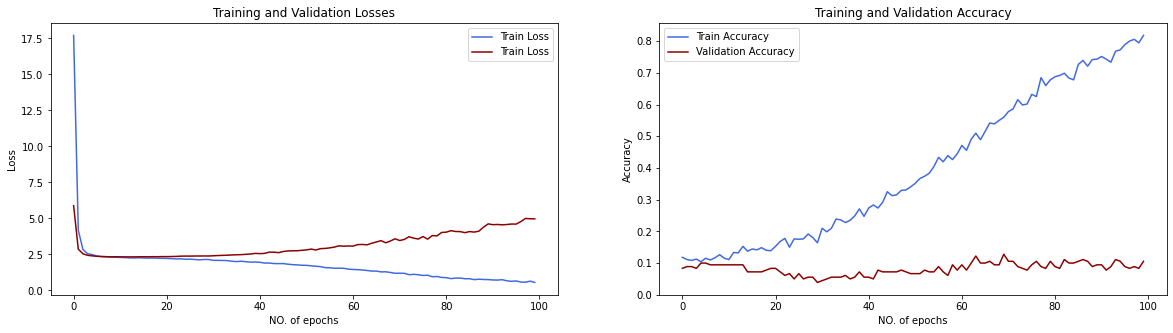

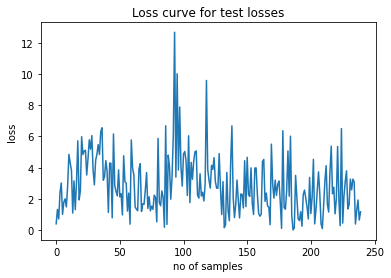

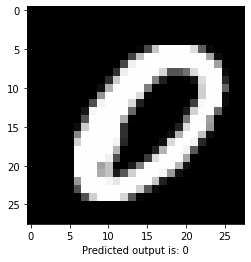

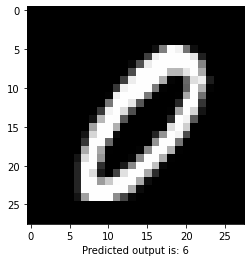

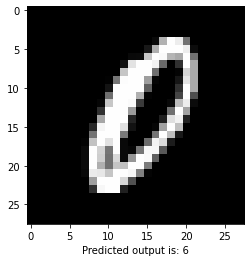

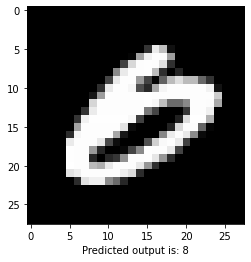

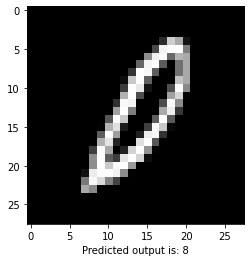

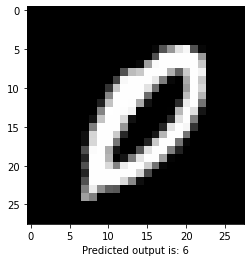

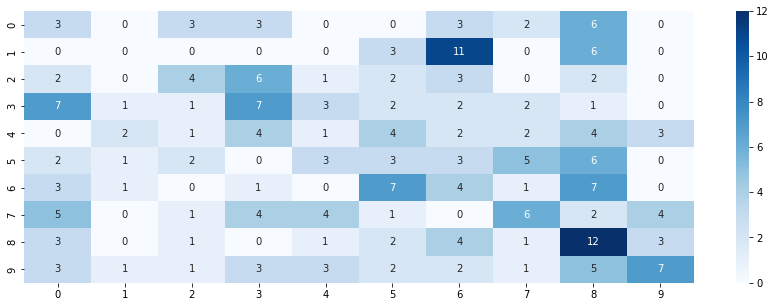

Classification_report is: 
               precision    recall  f1-score   support

           0       0.11      0.15      0.12        20
           1       0.00      0.00      0.00        20
           2       0.29      0.20      0.24        20
           3       0.25      0.27      0.26        26
           4       0.06      0.04      0.05        23
           5       0.12      0.12      0.12        25
           6       0.12      0.17      0.14        24
           7       0.30      0.22      0.26        27
           8       0.24      0.44      0.31        27
           9       0.41      0.25      0.31        28

    accuracy                           0.20       240
   macro avg       0.19      0.19      0.18       240
weighted avg       0.20      0.20      0.19       240

 Accuracy is: 0.19583333333333333


In [71]:
# #Loss function: Cross-entropy loss
# #Optimizer: Adam optimizer
# #Learning rate: 0.001-0.01
# #Number of epochs: 20-30
# #Number of hidden layers: 2-3
# #Number of neurons in each hidden layer: 128-256
# #batch size: 32-64
# #dropout: 0.2-0.5
# loss_fun = nn.CrossEntropyLoss()
# hiddenlayers = 4
# listof_HL = [400,200,100,50]
# drop = 0.2
# batch = 32
# optimizer = torch.optim.Adam
# learning = 0.001
# epochs = 20

# Over Fitting

loss_fun = nn.CrossEntropyLoss()
hiddenlayers = 1
listof_HL = [128]
drop = 0.2
batch = 32
optimizer = torch.optim.Adam
learning = 0.001
epochs = 100


main_function(training_path='/content/data/train',
              testing_path='/content/data/test',
              train_size=0.8,
              input_dim=784,
              no_of_hidden_layers=hiddenlayers,
              list_of_neurons=listof_HL, optimizer=optimizer,
              learning_rate=learning, no_of_epchos=epochs,
              loss_function=loss_fun, batch_size=batch,
              dropout=drop, is_model=True,
              Model_path='/content/drive/MyDrive/model_17.pt',
              visualize_results=True)

In [54]:
train_loader, test_loader, validation_loader = load_dataset(train_data_path='/content/data/train', train_size=0.8,
                                                                test_data_path='/content/data/test',
                                                                batch_Size=32,
                                                                Shuffle=True)

Training Images :  720 Validation Images 180 Testing Images 240
